In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import pi, sin, cos, dot

In [54]:
class TF:
    def __init__(self, n, d):
        self.index = n
        self.thickness = d
        
    def matrix(self, w):
        delta = 2*pi*(self.index)*(self.thickness)/w
        ita = self.index
        element = pd.DataFrame(
            {'e1':cos(delta), 'e2':1j/ita*sin(delta), 'e3':1j*ita*sin(delta), 'e4':cos(delta)}
        )
        matrix = np.reshape(element.values.reshape(1,-1), (np.size(w), 2, 2))
        return matrix
    
def Matrix_dot(layer_up, layer_bot): 
    w, _, _ = np.shape(layer_up)
    eq = [dot(layer_up[i], layer_bot[i]) for i in range(w)]
    return eq

def Eq_TF_Matrix(design):
    eq_matrix = design.pop()
    for i, layer in enumerate(design):
        eq_matrix = Matrix_dot(design[-i-1], eq_matrix)
    return eq_matrix

def Eq_admittance(eq, ns):
    d, _, _ = np.shape(eq)
    eq_y = dot(eq, np.array([[1], [ns]])) 
    Eq_y = pd.DataFrame(np.reshape(eq_y, (d, 2)), columns = ['B','C'])
    Y = Eq_y['C']/Eq_y['B']
    return Y.values.reshape(d, 1)
    
def Reflectance(eq, ns, n0):
    eq_Y = Eq_admittance(eq, ns)
    r = (n0-eq_Y)/(n0+eq_Y)
    R = np.reshape(r*r.conjugate(), np.size(eq_Y))
    return np.real(R)

In [183]:
def derivative(f1, f2, dx):
    return (f2 - f1)/dx

def FoM(hofx, target):
    merit = 100*sum(abs(hofx-target))
    return merit

In [184]:
target_w = np.linspace(400, 700, 500)
substrate = 1.5 # glass 
ambient = 1 # air
### layer information
IM1 = TF(2,58).matrix(target_w)
YITO = TF(1.9, 23).matrix(target_w)
Bridge = TF(1.8, 1200).matrix(target_w)
XITO = TF(1.9, 23).matrix(target_w)
IM2 = TF(2, 58).matrix(target_w)
PL = TF(1.4, 2000).matrix(target_w)
ITO = TF(1.9, 23).matrix(target_w)

In [185]:
n_IM1 = 2
n_IM2 = 2
n_ITO = 1.9
d_IM1 = 58
d_IM2 = 58
d_ITO = 23
step = 10**(-12)
w_target = np.linspace(400, 700, 500)

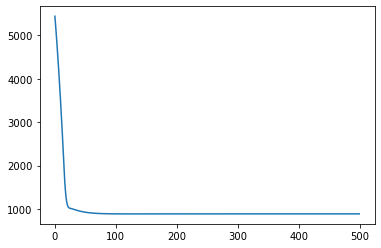

In [186]:
cost = []
costi = []
n_i = []
for i in range(500):
    alpha1 = 0.000001
    alpha2 = 0.000001
    ####
    IM1 = TF(n_IM1, d_IM1).matrix(w_target)
    IM2 = TF(n_IM2, d_IM2).matrix(w_target)
    tf_matrix = Eq_TF_Matrix([IM2, ITO, IM1])
    
    IM1_dn = TF(n_IM1+step, d_IM1).matrix(w_target)
    tf_matrix_dn1 = Eq_TF_Matrix([IM2, ITO, IM1_dn])
    
    IM2_dn = TF(n_IM2+step, d_IM2).matrix(w_target)
    tf_matrix_dn2 = Eq_TF_Matrix([IM2_dn, ITO, IM1])
    ####
    tf_matrix_target = Eq_TF_Matrix([IM1])
    R_target = Reflectance(tf_matrix_target, substrate, ambient)
    
    R_hofx = Reflectance(tf_matrix, substrate, ambient)
    R_hofx_dn1 = Reflectance(tf_matrix_dn1, substrate, ambient)
    R_hofx_dn2 = Reflectance(tf_matrix_dn2, substrate, ambient)
    
    J = FoM(R_hofx, R_target)
    J_dn1 = FoM(R_hofx_dn1, R_target)
    J_dn2 = FoM(R_hofx_dn2, R_target)
    ###    
    Grad_J1 = derivative(J, J_dn1, step)
    Grad_J2 = derivative(J, J_dn2, step)
    #print(J, J_dx)
    #print(Grad_J)
    #print(Grad_J)
    n_IM1 = n_IM1-alpha1*Grad_J1
    n_IM2 = n_IM2-alpha2*Grad_J2
    cost.append(J)
    costi.append(i)
    n_i.append([n_IM1,n_IM2])
plt.plot(costi, cost)
plt.show()

In [187]:
print(n_i[-1])

[1.7734431644857978, 2.0330346665577963]


In [119]:
nIM1 = 1.7734
nIM2 = 2.0333

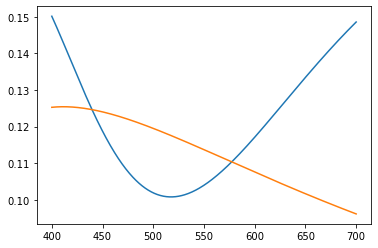

In [188]:
IM1 = TF(1.7734, 58).matrix(target_w)
IM2 = TF(2.0330, 58).matrix(target_w)
ITO = TF(1.9, 23).matrix(target_w)
tf_matrix_1 = Eq_TF_Matrix([IM2, ITO, IM1])
tf_matrix_2 = Eq_TF_Matrix([IM1])
R1 = Reflectance(tf_matrix_1, substrate, ambient)
R2 = Reflectance(tf_matrix_2, substrate, ambient)
plt.plot(w_target, R1, w_target, R2)
plt.show()

In [203]:
step = 10**(-12)
substrate = 1.5
ambient = 1

w_target = np.linspace(400, 700, 500)
IM1 = TF(1.7734, 58).matrix(w_target)
IM2 = TF(2.0330, 58).matrix(w_target)
ITO = TF(1.9, 23).matrix(w_target)
###
tf_matrix_1 = Eq_TF_Matrix([IM2, ITO, IM1])
tf_matrix_2 = Eq_TF_Matrix([IM1])
###
R1 = Reflectance(tf_matrix_1, substrate, ambient)
R2 = Reflectance(tf_matrix_2, substrate, ambient)

In [206]:
### dIM1_n
IM1_dn = TF(1.7734 + step, 58).matrix(w_target)
tf_matrix_1_dn1 = Eq_TF_Matrix([IM2, ITO, IM1_dn])
tf_matrix_2_dn1 = Eq_TF_Matrix([IM1_dn])
R1_dn1 = Reflectance(tf_matrix_1_dn1, substrate, ambient)
R2_dn1 = Reflectance(tf_matrix_2_dn1, substrate, ambient)
def delta_R(R1, R2):
    return sum(abs(R1- R2))
derivative(delta_R(R1, R2), delta_R(R1_dn1, R2_dn1), step)/5

-1.1610268302320037

In [207]:
### dIM2_n
IM2_dn = TF(2.0330 + step, 58).matrix(w_target)
tf_matrix_1_dn2 = Eq_TF_Matrix([IM2_dn, ITO, IM1])
tf_matrix_2_dn2 = Eq_TF_Matrix([IM1])
R1_dn2 = Reflectance(tf_matrix_1_dn2, substrate, ambient)
R2_dn2 = Reflectance(tf_matrix_2_dn2, substrate, ambient)
derivative(delta_R(R1, R2), delta_R(R1_dn2, R2_dn2), step)/5

0.04050093593832571

In [208]:
### dIM1_t
IM1_dt = TF(1.7734, 58+step).matrix(w_target)
tf_matrix_1_dt1 = Eq_TF_Matrix([IM2, ITO, IM1_dt])
tf_matrix_2_dt1 = Eq_TF_Matrix([IM1_dt])
R1_dt1 = Reflectance(tf_matrix_1_dt1, substrate, ambient)
R2_dt1 = Reflectance(tf_matrix_2_dt1, substrate, ambient)
derivative(delta_R(R1, R2), delta_R(R1_dt1, R2_dt1), step)/5

-0.06927791673660977

In [209]:
### dIM2_t
IM2_dt = TF(2.0330, 58+step).matrix(w_target)
tf_matrix_1_dt2 = Eq_TF_Matrix([IM2_dt, ITO, IM1])
tf_matrix_2_dt2 = Eq_TF_Matrix([IM1])
R1_dt2 = Reflectance(tf_matrix_1_dt2, substrate, ambient)
R2_dt2 = Reflectance(tf_matrix_2_dt2, substrate, ambient)
derivative(delta_R(R1, R2), delta_R(R1_dt2, R2_dt2), step)/5

-0.03339550858072471

In [210]:
### dITO_n
ITO_dn = TF(1.9+ step, 23).matrix(w_target)
tf_matrix_1_dnITO = Eq_TF_Matrix([IM2, ITO_dn, IM1])
tf_matrix_2_dnITO = Eq_TF_Matrix([IM1])
R1_dnITO = Reflectance(tf_matrix_1_dnITO, substrate, ambient)
R2_dnITO = Reflectance(tf_matrix_2_dnITO, substrate, ambient)
derivative(delta_R(R1, R2), delta_R(R1_dnITO, R2_dnITO), step)/5

2.305711177541525

In [211]:
### dITO_t
ITO_dt = TF(1.9, 23+step).matrix(w_target)
tf_matrix_1_dtITO = Eq_TF_Matrix([IM2, ITO_dt, IM1])
tf_matrix_2_dtITO = Eq_TF_Matrix([IM1])
R1_dtITO = Reflectance(tf_matrix_1_dtITO, substrate, ambient)
R2_dtITO = Reflectance(tf_matrix_2_dtITO, substrate, ambient)
derivative(delta_R(R1, R2), delta_R(R1_dtITO, R2_dtITO), step)/5

-0.04369837824924616